In [10]:
%matplotlib inline
%run analyze_traj.py
data_dir='/home/amichaut/Desktop/charlene/data/sub25/test/'
df,lengthscale,timescale,columns=get_data(data_dir,refresh=False)
df2=filter_by_traj_len(df,min_traj_len=25)
parallelize=False
x_grid_size=10

In [72]:
#### GENERATE SYNTHETIC DATA

part_num=10
frame_num=25
x0=10;y0=10;z0=10
xmax=100;ymax=100;zmax=100;
shift=50
traj=array([]);frame=array([]);x=array([]);y=array([]);z=array([])
for i in range(part_num):
    traj=np.concatenate((traj,ones(frame_num)*i))
    frame=np.concatenate((frame,arange(frame_num)))
    x=np.concatenate((x,linspace(x0,xmax,frame_num)))
    y=np.concatenate((y,linspace(y0+i*shift,ymax+i*shift,frame_num)))
    z=np.concatenate((z,linspace(z0,zmax,frame_num)))

a=np.vstack([arange(frame_num*part_num),traj,frame,x,y,z,zeros((6,frame_num*part_num))]).T
    
df=pd.DataFrame(a,columns=['i','traj','frame','x','y','z','m0','m1','m2','m3','m4','NPscore'])
savetxt('test_data.txt',a,delimiter='\t')

[-1, 7, -1, 7]

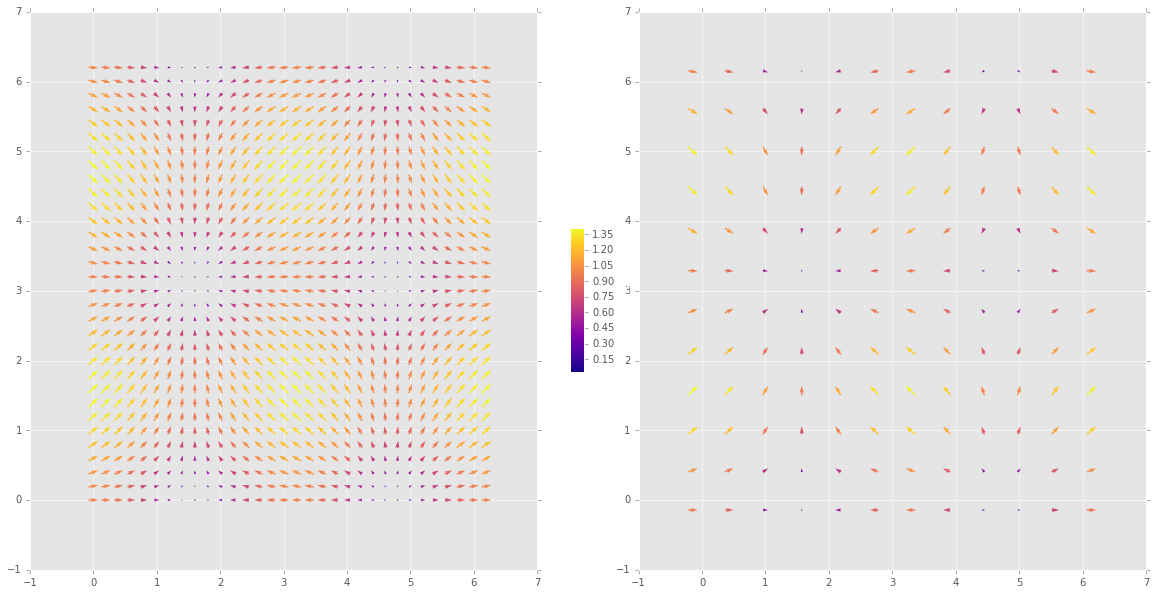

In [91]:
### TEST QUIVER

X, Y = np.meshgrid(np.arange(0, 2 * np.pi, .2), np.arange(0, 2 * np.pi, .2))
U = np.cos(X)
V = np.sin(Y)
fig, (ax, ax1) = plt.subplots(ncols=2, figsize=(20, 10))
M = np.hypot(U, V)
Q = ax.quiver(X, Y, U, V, M,
               units='x',
               pivot='mid',
               width=0.022,
               scale=1 / 0.15,
              cmap='plasma')

xmin, ymin, xmax, ymax=ax.axis()

cbaxes = fig.add_axes([0.5, 0.4, 0.01, 0.2]) 
cbar = fig.colorbar(Q,cax = cbaxes,label='$v_z\ (\mu m.min^{-1})$')
cbaxes.yaxis.label.set_color('white')
ax.axis([-1, 7, -1, 7])

### average grid

a=hstack([X.reshape(32*32,1),Y.reshape(32*32,1),U.reshape(32*32,1),V.reshape(32*32,1),M.reshape(32*32,1)])
df=pd.DataFrame(a,columns=['x','y','vx','vy','vz'])

#make subgrid
res=15
xmin, xmax, ymin, ymax = [-1, 7, -1, 7]
xsubgrid=linspace(xmin,xmax,res);ysubgrid=linspace(ymin,ymax,res)
X=[];Y=[];VX=[];VY=[];VZ=[] #new data
for i,xg in enumerate(xsubgrid[:-1]):
    for j,yg in enumerate(ysubgrid[:-1]):
        xg1=xsubgrid[i+1];yg1=ysubgrid[j+1]
        ind=((df['x']>=xg) & (df['x']<xg1) & (df['y']>=yg) & (df['y']<yg1))
        VX.append(df[ind]['vx'].mean());VY.append(df[ind]['vy'].mean());VZ.append(df[ind]['vz'].mean())
        X.append(xg+(xg1-xg)*0.5);Y.append(yg+(yg1-yg)*0.5) #center of the cell

Q = ax1.quiver(X,Y,VX,VY,VZ,
               units='x',
               pivot='mid',
               width=0.022,
               scale=1 / 0.15,
              cmap='plasma')

ax1.axis([-1, 7, -1, 7])

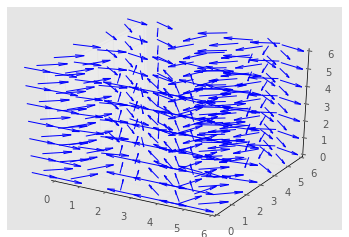

In [17]:
from mpl_toolkits.mplot3d import axes3d
fig = plt.figure()
ax = fig.gca(projection='3d')

step=1

x, y, z = np.meshgrid(np.arange(0, 2 * np.pi, step),
                      np.arange(0, 2 * np.pi, step),
                      np.arange(0, 2 * np.pi, step))

u = np.cos(x)
v = np.sin(y)
w = np.ones(x.shape)*(0)

ax.quiver(x, y, z, u, v, w, length=1)

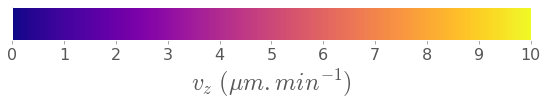

In [31]:
fig = figure(figsize=(8,3))
ax = fig.add_axes([0.05,0.80,0.9,0.15])
norm = plt.Normalize(vmin=0, vmax=10)
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cm.plasma,norm=norm,orientation='horizontal')
ax.tick_params(labelsize=16)
cb1.set_label(label='$v_z\ (\mu m.min^{-1})$',size=24)

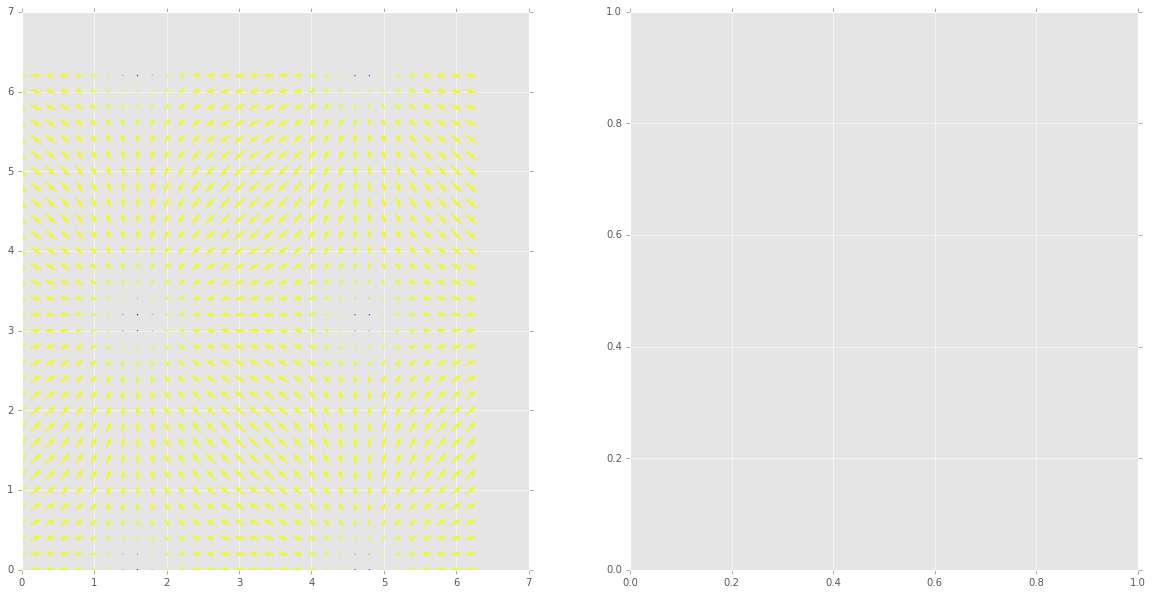

In [76]:
X, Y = np.meshgrid(np.arange(0, 2 * np.pi, .2), np.arange(0, 2 * np.pi, .2))
U = np.cos(X)
V = np.sin(Y)
fig, (ax, ax1) = plt.subplots(ncols=2, figsize=(20, 10))
M = np.hypot(U, V)
Q = ax.quiver(X, Y, U, V, M,
               units='x',
               pivot='mid',
               width=0.022,
               scale=1 / 0.15,
              cmap='plasma',
             norm=plt.Normalize(0,0.3))

In [77]:
isnan(np.nan)

True